## <span style="color:Red"> *HREF Vertical Profiles & WINTRE-MIX RAOB* </span>
---
<div class="alert alert-block alert-success">
<b>Notes:</b> Environment needs to be "daes_may 21"
</div>

#### **HREF Members Used:**
###### *Advanced Research Weather (HRW WRF-ARW), Finite Volume Cubed Sphere (HRW WRF-FV3), National Severe Storms Laboratory (HRW WRF-NSSL), North American Model (NAM 3km CONUS), High Resolution Rapid Refresh (HRRR)*

#### **WINTRE-MIX RAOB Sites:**
###### *UQAM - Sorel, McGill - Gault, CU DOW CAN S, CU DOW CAN N, UQAM - Trios-Rivieres, Albany - DOW-US Plattsburgh*

### HREF & Sounding Inputs & Output

skipping variable: paramId==156 shortName='gh'
Traceback (most recent call last):
  File "/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  925.,  850.,  700.,  500.,  300.,  250.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  850.,  700.,  500.]))
skipping variable: paramId==130 shortName='t'
Traceback (most recent call last):
  File "/network/rit/lab/snowclus/anaconda3_2021/envs/may21/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/netw

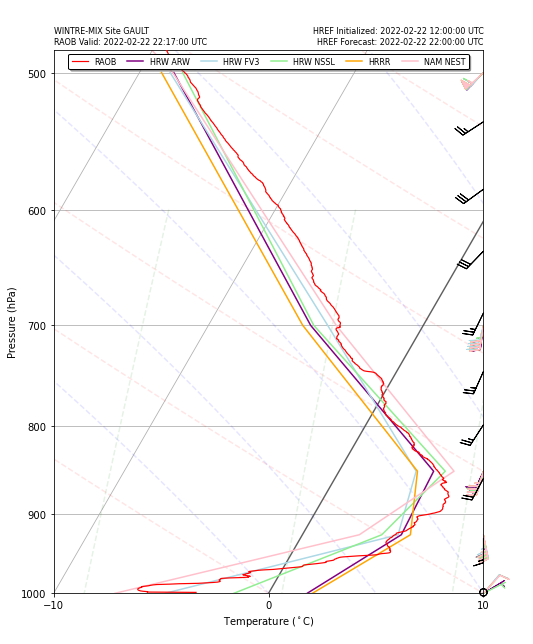

In [123]:
# HREF Initialization Time & NYSM Observation Starting Time
year = 2022 #2022
month = 2 #2
day = 22 #23
hour = 12 #6 
minute = 0 #0

# HREF Forecast Hour(s) (0, 6, 12, 18 UTC)
starthour = 10
endhour = 10

# SOUNDING CSV FILE GOES HERE!
sounding = '/network/rit/home/je845911/minlab/je845911/data/sounding/iop5/sounding/csv/upperair.sounding.202202222217.McGill-Gault.csv'

# DATE / TIME INFORMATION FROM FILENAME GOES HERE
YYYY = '2022'
MM = '02'
DD = '22'
HH = '22'
KK = '17'

# LOCATION @ WHICH RAOB LAUNCH OCCURED 
#(IOP4: UQAM-Sorel, McGill-Gault, DOW-CAN-S, DOW-US-Plattsburgh #COW-CAN?
#(IOP5: UQAM-Sorel, UQAM-Trois-Riviéres, McGill-Gault, DOW-CAN-N, DOW-US-N) #CU_DOW-CAN_S
Site = 'McGill-Gault'

# Sounding Launch Sites 
#(SOREL, GAULT, COW_CAN, DOW_CAN_S, DOW_US_Plattsburgh, TROIS-RIVERES, DOW_CAN_N, DOW_US_N)   
sound_sites = ['GAULT']



%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# Collections
from collections import Counter
from functools import reduce

# NetCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# Datetime
import datetime as dt
from datetime import datetime,timedelta

# Cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat 
from cartopy import feature as cfeature

# Matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot, USCOUNTIES, Hodograph, SkewT
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

# Above
inc = 1

# HREF File Grabbing
year_str = str(year)
month_str = str(month).zfill(2)
day_str = str(day).zfill(2)
hour_str = str(hour).zfill(2)
href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year_str + month_str + day_str + hour_str
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
endhour = endhour +1
fhrs = np.arange(starthour,endhour,inc)
length = len(fhrs)

arw, fv3, ncep, nssl, nam = [],[],[],[],[]
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

def get_nearest_gridpoint(xlat, xlong, slat, slon, verbose = False):
        abslat, abslon = np.fabs(xlat-slat), np.fabs(xlong-slon)
        c = np.maximum(abslon, abslat)
        xyloc = np.where(c == np.min(c))
        xs, ys = xyloc[1][0], xyloc[0][0]
        return (xs, ys)

for i in fhrs:

    # Time Dimension
    valid_time = datetime(year,month,day,hour,minute)
    D = int(((i-starthour)/inc)) # Used for HREF File Reference  
    time = (valid_time) + timedelta(hours=float(i)) 
    
    #Skew-T
    df = pd.read_csv(sounding, quotechar="'")

    if Site == 'CU_DOW-CAN_S':
        
        df.rename(columns= {
            '/Row/@Altitude':'Altitude','/Row/@DataSrvTime':'Time', 
            '/Row/@Dropping':'...','/Row/@East':'...',
            '/Row/@Height':'Height','/Row/@Humidity':'Humidity',
            '/Row/@North':'...','/Row/@Pressure':'Pressure',
            '/Row/@PtuStatus':'...','/Row/@RadioRxTimePk':'...',
            '/Row/@SoundingIdPk':'...','/Row/@Temperature':'Temperature',
            '/Row/@Up':'...','/Row/@WindDir':'Wind Direction',
            '/Row/@WindEast':'Wind U','/Row/@WindInterpolated':'...',
            '/Row/@WindNorth':'Wind V','/Row/@WindSpeed':'Wind Speed',
            '/Row/@Latitude':'Latitude','/Row/@Longitude':'Longitude',},inplace = True)
        
        n = 0  # TOA Problems
        df.drop(df.tail(n).index,inplace = True)
        df.drop_duplicates(inplace=True,subset='Pressure',ignore_index=True)
        p = df['Pressure'].values * units.hPa 
        T = df['Temperature'].values * units.degK
        u = df['Wind U'].values * units.knots
        v = df['Wind V'].values * units.knots
        
    elif Site == 'DOW-CAN-N':
                
        df.rename(columns= {
            '/Row/@Altitude':'Altitude','/Row/@DataSrvTime':'Time', 
            '/Row/@Dropping':'...','/Row/@East':'...',
            '/Row/@Height':'Height','/Row/@Humidity':'Humidity',
            '/Row/@North':'...','/Row/@Pressure':'Pressure',
            '/Row/@PtuStatus':'...','/Row/@RadioRxTimePk':'...',
            '/Row/@SoundingIdPk':'...','/Row/@Temperature':'Temperature',
            '/Row/@Up':'...','/Row/@WindDir':'Wind Direction',
            '/Row/@WindEast':'Wind U','/Row/@WindInterpolated':'...',
            '/Row/@WindNorth':'Wind V','/Row/@WindSpeed':'Wind Speed',
            '/Row/@Latitude':'Latitude','/Row/@Longitude':'Longitude',},inplace = True)
        
        n = 0  # TOA Problems
        df.drop(df.tail(n).index,inplace = True)
        df.drop_duplicates(inplace=True,subset='Pressure',ignore_index=True)
        p = df['Pressure'].values * units.hPa 
        T = df['Temperature'].values * units.degK
        u = df['Wind U'].values * units.knots
        v = df['Wind V'].values * units.knots
        
    else:
        df = df.drop([0,1])
        df.drop(df.tail(0).index,inplace = True)
        df.drop_duplicates(inplace=True,subset='Press',ignore_index=True)
        p = df['Press'].values.astype(float) * units.hPa  # Now numbers with units also attached. [ * units.hPa also works]
        T = df['Temp'].values.astype(float) * units.degC   
        Speed = df['WSpeed'].values.astype(float)*units.knots
        Direction = df['WDirn'].values.astype(float)*units.degrees
        u,v = mpcalc.wind_components(Speed, Direction)
        
        
    # HREF Point Profiles
    for x in sound_sites:
        if x == 'SOREL':
            xlat,xlon = 46.030244, -73.110328 + 360
        elif x == 'TROIS-RIVERES':
            xlat,xlon = 46.349836, -72.581353 + 360
        elif x == 'GAULT':
            xlat,xlon = 45.535022, -73.149006 + 360
        elif x == 'COW_CAN':
            xlat,xlon = 45.478247, -72.936154 + 360
        elif x == 'DOW_CAN_S':
            xlat,xlon = 45.085246, -73.271936 + 360
        elif x == 'DOW_CAN_N':
            xlat,xlon = 45.704814, -72.644103 + 360
        elif x == 'DOW_US_Plattsburgh':
            xlat,xlon = 44.684823, -73.526291 + 360
        elif x == 'DOW_US_N':
            xlat,xlon = 44.955432, -73.387857 + 360

        with xr.open_dataset(arw[D],engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) as arw_:
            arw_t = arw_['t']-273.15
            arw_u = arw_['u']*1.94384
            arw_v = arw_['v']*1.94384

        with xr.open_dataset(fv3[D],engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) as fv3_:
            fv3_t = fv3_['t']-273.15
            fv3_u = fv3_['u']*1.94384
            fv3_v = fv3_['v']*1.94384

        with xr.open_dataset(nssl[D],engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) as nssl_:
            nssl_t = nssl_['t']-273.15
            nssl_u = nssl_['u']*1.94384
            nssl_v = nssl_['v']*1.94384
            
        with xr.open_mfdataset(ncep[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130}) as ncep_:
            ncep_t = ncep_['t']-273.15
            
        with xr.open_dataset(ncep[D],filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) as ncep_w:
            ncep_u = ncep_w['u']*1.94384
            ncep_v = ncep_w['v']*1.94384
            
        with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':130}) as nam_:
            nam_t = nam_['t']-273.15
        with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':131}) as nam__:
            nam_u = nam__['u']*1.94384
        with xr.open_mfdataset(nam[D], engine = 'cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isobaricInhPa', 'paramId':132}) as nam___:
            nam_v = nam___['v']*1.94384
            
        # Gridpoint Derivation
        gridpoints = get_nearest_gridpoint(arw_t['latitude'],arw_t['longitude'],xlat,xlon, verbose = True)
        station_x, station_y = gridpoints[0], gridpoints[1]        
        
        # Data based on location
        arw_t = arw_t.sel(y = station_y , x = station_x).values
        arw_t = np.float32(arw_t) * units.celsius
        arw_u = arw_u.sel(y = station_y , x = station_x).values
        arw_u = np.float32(arw_u) * units.knots
        arw_v = arw_v.sel(y = station_y , x = station_x).values
        arw_v = np.float32(arw_v) * units.knots

        fv3_t = fv3_t.sel(y = station_y , x = station_x).values
        fv3_t = np.float32(fv3_t) * units.celsius
        fv3_u = fv3_u.sel(y = station_y , x = station_x).values
        fv3_u = np.float32(fv3_u) * units.knots
        fv3_v = fv3_v.sel(y = station_y , x = station_x).values
        fv3_v = np.float32(fv3_v) * units.knots

        nssl_t = nssl_t.sel(y = station_y , x = station_x).values
        nssl_t = np.float32(nssl_t) * units.celsius
        nssl_u = nssl_u.sel(y = station_y , x = station_x).values
        nssl_u = np.float32(nssl_u) * units.knots
        nssl_v = nssl_v.sel(y = station_y , x = station_x).values
        nssl_v = np.float32(nssl_v) * units.knots

        ncep_t = ncep_t.sel(y = station_y , x = station_x).values
        ncep_t = np.float32(ncep_t) * units.celsius
        ncep_u = ncep_u.sel(y = station_y , x = station_x).values
        ncep_u = np.float32(ncep_u) * units.knots
        ncep_v = ncep_v.sel(y = station_y , x = station_x).values
        ncep_v = np.float32(ncep_v) * units.knots

        nam_t = nam_t.sel(y = station_y , x = station_x).values
        nam_t = np.float32(nam_t) * units.celsius
        nam_u = nam_u.sel(y = station_y , x = station_x).values
        nam_u = np.float32(ncep_u) * units.knots
        nam_v = nam_v.sel(y = station_y , x = station_x).values
        nam_v = np.float32(ncep_v) * units.knots

        # Graph Parameters
        b_alpha = .1
        arw_l = [1000,925,850,700,500]* units.hPa
        nam_l = [1000,925,850,700,500,250]* units.hPa # Adjusted
        ncep_l = [1000,925,850,700,500,2,1]* units.hPa # Adjusted
        nam_w = [1000,925,850,700,500,250,1]* units.hPa # Adjusted
        
        tl0 = f'WINTRE-MIX Site {x}'
        tl1 = f'RAOB Valid: {YYYY}-{MM}-{DD} {HH}:{KK}:00 UTC'
        tl2 = f'HREF Initialized: {valid_time} UTC'
        tl3 = f'HREF Forecast: {time} UTC'
        
        title_line_left = (tl0+ '\n' + tl1)
        title_line_right = (tl2+ '\n' +tl3)
        lc1,lc2,lc3,lc4,lc5 = '#984ea3','#377eb8','#4daf4a','#ff7f00','pink'
        svt = f'vert_temp_{x}_{YYYY}{MM}{DD}{HH}{KK}'
        
        # Figure
        fig = plt.figure(figsize=(15,10))
        skew = SkewT(fig, rotation=30)
        skew.plot_dry_adiabats(alpha = b_alpha)
        skew.plot_moist_adiabats(alpha = b_alpha)
        skew.plot_mixing_lines(alpha = b_alpha)
        skew.ax.axvline(0 * units.degC, color='black',alpha = .5) 
        skew.ax.set_xlim(-10,10)  
        skew.ax.set_ylim(1000,485)
        
        #Winds
        idx = 135
        mask = p >= 500 * units.hPa
        
        plt.title(title_line_left,fontsize=8,loc = 'left')
        plt.title(title_line_right,fontsize=8,loc = 'right')
        plt.xlabel("Temperature ($^\circ$C)",fontsize = 10)
        plt.ylabel("Pressure (hPa)",fontsize = 10)
        
        # HREF Profiles
        skew.plot(p, T, 'red', label = 'RAOB', linewidth = 1.2, zorder =3)
        skew.plot(arw_l, arw_t, lc1, label = 'HRW ARW', zorder =2, color = 'purple')
        skew.plot(arw_l, fv3_t, lc2,label = 'HRW FV3', zorder = 2, color = 'lightblue')
        skew.plot(arw_l, nssl_t, lc3, label = 'HRW NSSL', zorder =2, color = 'lightgreen')
        skew.plot(arw_l, ncep_t, lc4, label = 'HRRR', zorder = 2, color = 'orange')
        skew.plot(nam_l, nam_t, lc5, label = 'NAM NEST', zorder =2)
        
        # HREF Wind Profiles
        mask_ = arw_l >= 500 * units.hPa
        mask__= ncep_l >= 500 * units.hPa
        mask___= nam_w >= 500 * units.hPa

        idx_ = 1
        skew.plot_barbs(arw_l[mask_][::idx_], arw_u[mask_][::idx_],arw_v[mask_][::idx_], color = 'purple', xloc = 1)  
        skew.plot_barbs(arw_l[mask_][::idx_], fv3_u[mask_][::idx_],fv3_v[mask_][::idx_], color = 'lightblue', xloc = 1)  
        skew.plot_barbs(arw_l[mask_][::idx_], nssl_u[mask_][::idx_],nssl_v[mask_][::idx_], color = 'lightgreen', xloc = 1)  
        skew.plot_barbs(ncep_l[mask__][::idx_], ncep_u[mask__][::idx_],ncep_v[mask__][::idx_], color = 'orange')  
        skew.plot_barbs(nam_w[mask___][::idx_], nam_u[mask___][::idx_],nam_v[mask___][::idx_], color = 'pink')  
        skew.plot_barbs(p[mask][::idx], u[mask][::idx],v[mask][::idx])  

        # Legend
        plt.legend(loc='upper center',frameon=True,fontsize=8,shadow = True,edgecolor = 'black',mode = "expand", ncol = 6,bbox_to_anchor=(0.025, -.25, .95,1.25)) #(0.20, -.05, 0.6,1.3))
        
        # Savefigure
        fig.savefig(svt)

England, John | LU:20230129